In [71]:
import pandas as pd


def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

dic = unpickle('data_batch_1')

In [120]:
from sklearn.model_selection import train_test_split
import torch.utils.data as Data
import torch
import torchvision

batch_sizes = 32

y = dic[b'labels']
x = dic[b'data']
x = x.reshape(10000,3,32,32)
# y = y[:2000]
# x = x[:2000]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2004)

x_train_tensor = torch.FloatTensor(x_train)
y_train_tensor = torch.LongTensor(y_train)
x_test_tensor = torch.FloatTensor(x_test)
y_test_tensor = torch.LongTensor(y_test)



trans =[]
trans.append(torchvision.transforms.Resize(224))
transform = torchvision.transforms.Compose(trans) 
x_train_tensor = transform(x_train_tensor) 
x_test_tensor = transform(x_test_tensor)

train_dataset = Data.TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = Data.TensorDataset(x_test_tensor, y_test_tensor)

train_dataloader = Data.DataLoader(train_dataset,batch_sizes,shuffle=True)
test_dataloader = Data.DataLoader(test_dataset,batch_sizes,shuffle=True)

In [121]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class InceptionModule(nn.Module):
    def __init__(self, in_channels, out1x1, red3x3, out3x3, red5x5, out5x5, out1x1pool):
        super().__init__()
        # 1
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out1x1, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        # 2
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, red3x3, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(red3x3, out3x3, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        # 3
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, red5x5, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(red5x5, out5x5, kernel_size=5, padding=2),
            nn.ReLU(inplace=True)
        )
        # 4
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out1x1pool, kernel_size=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        
        branch1_output = self.branch1(x)
        branch2_output = self.branch2(x)
        branch3_output = self.branch3(x)
        branch4_output = self.branch4(x)
        output = torch.cat([branch1_output, branch2_output, branch3_output, branch4_output], 1)
        return output

class GoogLeNet(nn.Module):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.inception4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.inception5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool(x)
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        x = torch.softmax(x, dim=-1)
        return x





In [122]:
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss = nn.CrossEntropyLoss()
model = GoogLeNet(num_classes = 10).to(device)
optimizer = optim.Adam(model.parameters(),lr = 1e-5)


In [123]:



def train_model(dataloader):
    model.train()
    
    total_loss = 0
    for idx,(x,y) in enumerate(dataloader):     
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        cur_loss = loss(y_pred,y)
        optimizer.zero_grad()
        cur_loss.backward()
        optimizer.step()
        
        total_loss += cur_loss.item()
    print(f"train loss:{total_loss/idx}")
    model.eval()
    return total_loss/idx

In [124]:
def test_model(dataloader):
    model.eval()
    
    total_loss = 0
    for idx,(x,y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        cur_loss = loss(y_pred,y)
        
        total_loss += cur_loss.item()
    print(f"train loss:{total_loss/idx}")
    return total_loss/idx

==== Epoch 1 ====
train loss:2.311824100563325
train loss:2.3395410853047527
==== Epoch 2 ====
train loss:2.274340087630184
train loss:2.2548305257674186
==== Epoch 3 ====
train loss:2.2352073221321564
train loss:2.240469986392606
==== Epoch 4 ====
train loss:2.220009409280187
train loss:2.261403710611405
==== Epoch 5 ====
train loss:2.214998065228443
train loss:2.2266011007370485
==== Epoch 6 ====
train loss:2.2042244179660537
train loss:2.2203228166026454
==== Epoch 7 ====
train loss:2.19964709195746
train loss:2.21459367967421
==== Epoch 8 ====
train loss:2.1964118935496932
train loss:2.211370725785532
==== Epoch 9 ====
train loss:2.1972814286090285
train loss:2.2146546456121627
==== Epoch 10 ====
train loss:2.1921022196850144
train loss:2.2100461106146536
==== Epoch 11 ====
train loss:2.1826453491387117
train loss:2.2011824423266995
==== Epoch 12 ====
train loss:2.1833845003541694
train loss:2.2361338792308683
==== Epoch 13 ====
train loss:2.1827727929655327
train loss:2.2001842029

<function matplotlib.pyplot.show(close=None, block=None)>

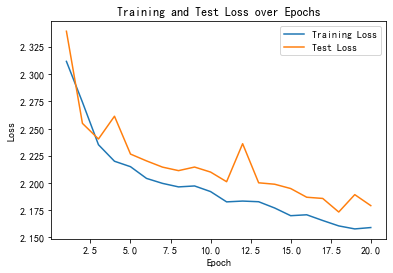

In [125]:
import matplotlib.pyplot as plt

num_epoch = 20
train_losses = []
test_losses = []

for i in range(num_epoch):
    print(f"==== Epoch {i+1} ====")
    train_loss = train_model(train_dataloader)
    test_loss = test_model(test_dataloader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)



plt.plot(range(1, num_epoch + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epoch + 1), test_losses, label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()

plt.show